In [58]:
!pip install -q pyomo

In [59]:
from pyomo.environ import *
import itertools

In [60]:
def input(filename):
    with open(filename) as f:
        n, k = [int(x) for x in f.readline().split()]
        d = [[int(x) for x  in f.readline().split()] for i in range(n + 1)]
        for i in range(n+1):
            d[i].append(d[i][0])
        return n, k, d
    
n, k , d = input('/content/data1.txt')
K = list(range(1,k+1))
Nrow = list(range(n+1))
Ncol = list(range(1,n+2))

A = []
for i in range(n+1):
    for j in range(1,n+2):
        if (i != j) and (i,j) != (0,n+1):
            A.append([i,j])
Ao = lambda x: [j for i, j in A if i == x]
Ai = lambda x: [i for i, j in A if j == x]

In [62]:
# Model
model = ConcreteModel()

# Decision variables
model.x = Var(K, Nrow, Ncol, within=Binary)
model.z = Var(within=NonNegativeReals)

# Constraints
model.cstr1 = ConstraintList()
for i in range(1,n+1):
    model.cstr1.add(sum(model.x[p,i,j] for p in K for j in Ao(i)) == 1)

model.cstr2 = ConstraintList()
for i in range(1,n+1):
    for p in K:
        model.cstr2.add(sum(model.x[p,i,j] for j in Ao(i)) - sum(model.x[p,j,i] for j in Ai(i)) == 0)

model.cstr3 = ConstraintList()
for p in K:
    model.cstr3.add(sum(model.x[p,0,j] for j in Ao(0)) == 1) 
    model.cstr3.add(sum(model.x[p,i,n+1] for i in Ai(n+1)) == 1)
    model.cstr3.add(sum(model.x[p,i,j]*d[i][j] for i,j in A) - model.z <= 0)
  
def findSubset(n,m):
    lst = [int(i) for i in range(n)]
    return set(itertools.combinations(lst,m))  
model.cstr5 = ConstraintList()
for p in K:
    for length in range(2, n+1):
        subs = findSubset(n+1,length)
        for u in subs:
            model.cstr5.add(sum(model.x[p,i,j] for i,j in A if (i in u) and (j in u)) <= length-1)

                  
# Objective
def obj1(model):
    return model.z
model.obj1 = Objective(rule=obj1, sense=minimize)

def obj2(model):
    return sum(d[i][j]*model.x[k,i,j] for k in K for i,j in A) 
model.obj2 = Objective(rule=obj2, sense=minimize)

# model.pprint()

In [63]:
!apt-get install -y -qq glpk-utils

In [64]:
model.f1 = Var()
model.f2 = Var()
model.c1 = Constraint(expr = model.f1 == model.z)
model.c2 = Constraint(expr = model.f2 == sum(d[i][j]*model.x[k,i,j] for k in K for i,j in A))

# min obj1 separately
model.obj2.deactivate()
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')  
solver.solve(model)
print('minimize the length of the longest tour')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f1_min = value(model.f1)

# min obj2 separately
# model.obj1.deactivate()
# model.obj2.activate()
# solver = SolverFactory('glpk', executable='/usr/bin/glpsol')  
# solver.solve(model)
# f1_max = value(model.f1)
# print('minimize the total cost of all vehicles routes')
# print('f1 = ' + str(value(model.f1)))
# print('f2 = ' + str(value(model.f2)))

minimize the length of the longest tour
f1 = 22.0
f2 = 63.0


In [65]:
model.cstr6 = ConstraintList()
for p in K:
    model.cstr6.add(sum(model.x[p,i,j]*d[i][j] for i,j in A) - f1_min <= 0)

model.obj1.deactivate()
model.obj2.activate()
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')  
solver.solve(model)
f2_min = value(model.f2)
print('obj1 = ', f1_min, 'obj2 = ', f2_min)

obj1 =  22.0 obj2 =  63.0


In [76]:
def findNext(p,i):
    for j in Ao(i):
	    if value(model.x[p,i,j]) > 0:
		    return j
def route(p):
    s = '0->'
    i = findNext(p,0)
    while i != n+1:
        s = s + str(i) + '->'
        i = findNext(p,i)
    s = s + str(0)
    return s
    
for p in K:
    l = 0
    print()
    for i,j in A:
        if value(model.x[p,i,j]) > 0:
            l += d[i][j]
            if j != n+1:
	            print('('+str(i)+'-'+str(j)+')')
            else:
                print('('+str(i)+'-'+str(j)+')')	
    print('Route[' + str(p) +']: '+ route(p), '\nLength =', l)


(0-6)
(4-8)
(6-4)
Route[1]: 0->6->4->0 
Length = 22

(0-7)
(1-8)
(2-1)
(3-2)
(7-3)
Route[2]: 0->7->3->2->1->0 
Length = 21

(0-5)
(5-8)
Route[3]: 0->5->0 
Length = 20


In [48]:
# epsilon-constraint
# MIN f2 - delta*s
# constraint f1 - s == e
# model.obj1.activate()
# model.obj2.deactivate()

# model.del_component(model.obj1)
# model.del_component(model.obj2)

# model.e = Param(initialize=0, mutable=True)
# model.delta = Param(initialize=0.001)
# model.slack = Var(within=NonNegativeReals)

# model.obj1 = Objective(expr = model.f1 - model.delta * model.slack, sense=minimize)
# model.C_e = Constraint(expr = model.f2 - model.slack == model.e)

# steps = list(range(int(f1_min),int(f1_max)+1,1))
# f1_l, f2_l = [], []
# for i in steps:
#     model.e = i
#     solver.solve(model)
#     f1_l.append(value(model.f1))
#     f2_l.append(value(model.f2))

In [50]:
# import matplotlib.pyplot as plt

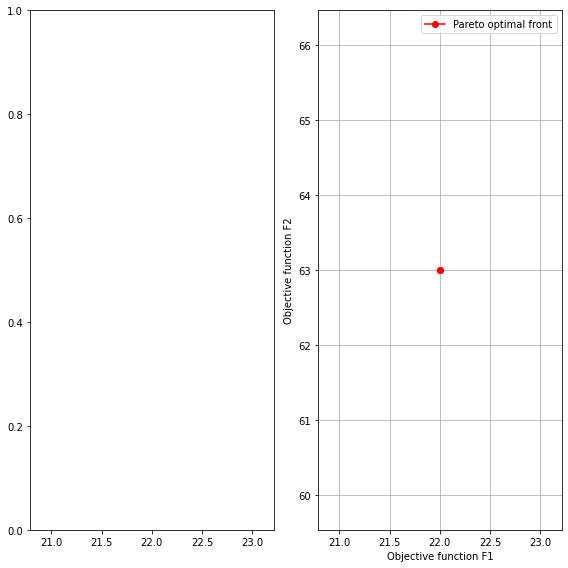

In [51]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(8,8))

# ax2.plot(f1_l, f2_l, 'o-', c='r', label='Pareto optimal front')
# ax2.legend(loc='best')
# ax2.set_xlabel('Objective function F1')
# ax2.set_ylabel('Objective function F2')
# ax2.grid(True)
# fig.tight_layout()
plt.show()